<a href="https://colab.research.google.com/github/Z3376/Apparel_Classifier/blob/master/ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Terminal

In [0]:
%%bash
pip install torch
pip install fastai
wget -O twitter_airline.zip "https://storage.googleapis.com/kaggle-data-sets/17/742210/compressed/Tweets.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1573591561&Signature=kkqLBkOy4Vy73TFR66bJOWp3Ilk3%2FFbhlMK%2BlcXHRWoD1Oaxin3ieJVw0%2FIjpCJ3nWtvJb%2Fq%2FhQd%2BoGAVLacRB%2BNYegfAlPxAq8xlesRfM3P5Rsdge6VaCPwvhtJMPWCX46jOH4oPVdwoea5La9FnIU2jbRBsvxBFhqVwzP00CXpG5%2FVnGojolxBDl%2FB%2FbVAd%2BiBFYRhAWbN7pIAswVKv%2F%2FuJ2YbREBRa%2BBE20Mv6PDfoG85MkDmGcRDV5UqqhvpejU%2FVrn0itcpIAHXfDVOpr%2B0kRT3aG30i9xOYcswpFTg47Mm%2FREe3X%2B9C2SKSVfdJMhmISIs031Iq6D%2F%2FKqPFQ%3D%3D&response-content-disposition=attachment%3B+filename%3DTweets.csv.zip"
unzip twitter_airline.zip
wget -O twitter_text.zip "https://storage.googleapis.com/kaggle-data-sets/2477/4140/compressed/training.1600000.processed.noemoticon.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1573603378&Signature=GGXrS20UOzSiGbMa%2Fop3ufInSh1haJCAci4ph5297QZQT1h9Dykd%2BulbHsUSY%2BpTQuQvh0aTbxB%2FVuveJRzn101vHR1gCUffDzV8qplSDfa0MxgV%2FVhE%2FjNki4plz6JZ7AcNc%2BcShkE5jg4yP5zJKu3PMB91Mttyi30wo5YSckfSZKmueRsiWl2eIgtNZ7W2UsCKNkIZUxNuphKInJbA6rQOB3wuXRb1YGv%2BmmbvSy8j25%2FgQ0X0XsoiTVEmio1iFjXyKM21mGGx3knodgkf3GL3A3to4Co2KduyEIzCUBOOYcRAOwy1ErhyiwmLVQ0DtRiCbD7E71uF%2F97AIGiGGQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining.1600000.processed.noemoticon.csv.zip"
unzip twitter_text.zip

# Imports

In [5]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data

In [0]:
"""
Loading Data
"""
df = pd.read_csv('Tweets.csv')
# lm_df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin-1',header=None,names=['id','date','flag','user','text'])

In [0]:
"""
Cleaning Data
"""
df = df[df['airline_sentiment_confidence']==1].reset_index(drop=True)

In [0]:
df = df[['airline_sentiment','text']]
df.columns = ['label','text']

In [9]:
df.shape

(10445, 2)

# Unbalanced Dataset

## Preprocessing

In [10]:
print(df['label'].value_counts())

negative    7382
neutral     1548
positive    1515
Name: label, dtype: int64


In [11]:
"""
Removing special characters
"""
# df['text'] = df['text'].str.replace("[^a-zA-Z0-9]", " ")

'\nRemoving special characters\n'

In [0]:
"""
Tokenizing and stopword removal
""" 
tokenized_corp = df['text'].transform(lambda x: x.split())
stop_words = set(stopwords.words('english'))
tokenized_corp = tokenized_corp.transform(lambda x: [item for item in x if item not in stop_words])

In [0]:
"""
De-Tokenizing
"""
detokenized_corp = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_corp[i]) 
    detokenized_corp.append(t) 

df['text'] = detokenized_corp

In [0]:
"""
Split into training and validation set
"""
df_train,df_val = train_test_split(df, stratify=df['label'], test_size=0.25)

In [15]:
print(df_train.shape)
print(df_val.shape)

(7833, 2)
(2612, 2)


## Language Model

In [0]:
"""
Language model (LM) data
"""
lm_data = TextLMDataBunch.from_df(train_df=df_train, valid_df=df_val, path="")

In [0]:
"""
Loading pre-trained LM
"""
learner = language_model_learner(lm_data,pretrained=True,drop_mult=0.7,arch=AWD_LSTM)

In [18]:
"""
Finetuning pre-trained LM with LSTM layers freezed
opt = Adam
"""
learner.freeze_to(-1)
learner.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.574851,5.002368,0.188068,00:03
1,5.430336,4.458969,0.235653,00:03
2,4.915076,4.417841,0.239448,00:03


In [19]:
"""
Finetuning complete LM with discriminative learning
"""
learner.unfreeze()
lr  = 1e-2
lrm = 2.6
lrs = np.array([lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learner.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,4.412913,4.246438,0.258787,00:04
1,4.229350,4.143929,0.266031,00:04
2,3.988394,4.120975,0.268912,00:04
3,3.736066,4.169859,0.267857,00:04
4,3.512068,4.184694,0.270373,00:04


In [21]:
learner.show_results()

text,target,pred
xxbos @united xxmaj thanks xxunk ? xxmaj you guys 3 hours extra get bag due delay . xxmaj so that,'s 7 hours had . # fail ! xxbos @usairways xxmaj just xxunk xxup xxunk xxup news ripoff xxmaj cancelled,'s good hour . . xxbos xxunk xxbos xxbos @united xxmaj you got . xxunk xxup xxunk . ! cancelled
ground staff false promises xxmaj twitter xxunk xxbos @americanair @dfwairport 2 together best part flying ! xxbos @jetblue xxmaj thanks,. xxmaj used phone instead computer worked ! ! xxmaj thx again ! xxbos @southwestair bad i 'm getting xxunk,! xxmaj you first system . . . xxbos xxbos thanks ! ! xxbos @united xxmaj weather 'm trying xxunk
"- disaster ! xxmaj flight xxunk , missed passenger count 5 since done xxunk ! ! xxmaj really ? ?","? xxbos @united xxmaj no , thanks . i 'm sick company 's lousy excuse customer service . i 'm","xxbos xxbos @united xxmaj thanks , i . xxmaj 'm sure . . bad service . service . xxmaj 'm"
schedule . xxmaj no xxunk xxup phl xxup fll xxup pbi ? xxmaj we free move cities . xxmaj sad,". xxbos @united tried . xxmaj it 's already cancun one delivered xxbos @united i voucher expires next week ,",. xxbos @united xxmaj calling xxmaj you 's xxup xxmaj . way . @united xxmaj 'm flight month day .
"xxmaj we 've waited patiently , mention $ 150 six months marathon training , need 2 tmrw . xxbos @united",xxunk xxunk mean treat frequent fliers like crap . xxbos @united least 3 us xxup xxunk xxup ord waiting deplane,xxmaj xxmaj xxmaj ? customers flyer ? flyers . xxmaj @united xxmaj could hours xxunk us xxup xxunk xxup gate


In [0]:
"""
Saving LM encoder
"""
learner.save_encoder('lm_enc')

## Classifier

In [0]:
"""
Classifier model data
"""
classifier_data = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df=df_val, vocab=lm_data.train_ds.vocab, bs=32)

In [102]:
"""
Creating classifier model with LM encoder weights
"""
learner = text_classifier_learner(classifier_data, drop_mult=1.5,arch=AWD_LSTM)
learner.load_encoder('lm_enc')
print('Done')

Done


In [103]:
"""
Training classifier with gradual unfreezing and discriminative learning
"""
lr  = 1e-2
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learner.freeze_to(-1)
learner.fit(1, lrs)
learner.save('clas_0')

epoch,train_loss,valid_loss,accuracy,time
0,0.797672,0.638611,0.762251,00:03


In [104]:
learner.freeze_to(-2)
learner.fit(3, lrs)
learner.save('clas_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.753620,0.643058,0.721286,00:04
1,0.760092,0.538327,0.802833,00:04
2,0.746219,0.476710,0.832312,00:04


In [105]:
learner.unfreeze()
learner.fit_one_cycle(85, lrs)
learner.save('clas_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.704296,0.476889,0.830398,00:07
1,0.714671,0.471136,0.831547,00:07
2,0.706821,0.469644,0.832695,00:07
3,0.694477,0.471255,0.824273,00:07
4,0.706179,0.476596,0.818530,00:07
5,0.734919,0.473537,0.823507,00:07
6,0.683292,0.465431,0.830015,00:07
7,0.678459,0.452379,0.835758,00:07
8,0.681269,0.444570,0.835375,00:07
9,0.706382,0.465955,0.823507,00:07


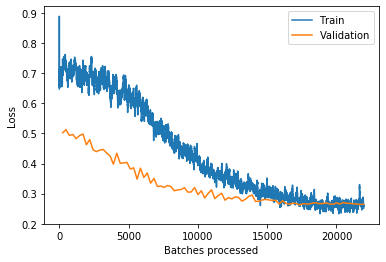

In [95]:
learner.recorder.plot_losses()

## Results

In [0]:
"""
Predictions
"""
preds, targets = learner.get_preds()
predictions = np.argmax(preds, axis = 1)

In [107]:
"""
Confusion Matrix
"""
cm = pd.crosstab(predictions, targets)
print(cm)

col_0     0    1    2
row_0                
0      1767   90   29
1        54  274   12
2        25   23  338


In [108]:
"""
Accuracy
"""
acc = np.sum([cm[i][i] for i in range(3)])/np.sum(np.sum(cm))
print('Accuracy: %.3f'%acc)

0.9108


In [109]:
"""
Precision
"""
prec = [0 for i in range(3)]
for i in range(3):
    prec[i] = round(cm[i][i]/np.sum(cm,axis=1)[i],3)
print(prec)

[0.937, 0.806, 0.876]


In [110]:
"""
Recall
"""
rec = [0 for i in range(3)]
for i in range(3):
    rec[i] = round(cm[i][i]/np.sum(cm)[i],3)
print(rec)

[0.957, 0.708, 0.892]


In [111]:
"""
F1 score
"""
f1 = [round(2*prec[i]*rec[i]/(prec[i]+rec[i]),3) for i in range(3)]
print(f1)

[0.947, 0.754, 0.884]


# Balanced Dataset

## Preprocessing

In [0]:
"""
Balancing data: keeping only 30% of 'negative' class
"""
df_neg = df[df['label']=='negative']
df_neg = df_neg.sample(frac=0.3).reset_index(drop = True)

df_non_neg = df[df['label']!='negative'].reset_index(drop = True)

df = pd.concat([df_neg,df_non_neg],axis=0).reset_index(drop = True)
df = df.sample(frac=1).reset_index(drop = True)

In [113]:
print(df['label'].value_counts())

negative    2215
neutral     1548
positive    1515
Name: label, dtype: int64


In [114]:
"""
Removing special characters
"""
# df['text'] = df['text'].str.replace("[^a-zA-Z0-9]", " ")

'\nRemoving special characters\n'

In [0]:
"""
Tokenizing and stopword removal
""" 
tokenized_corp = df['text'].transform(lambda x: x.split())
stop_words = set(stopwords.words('english'))
tokenized_corp = tokenized_corp.transform(lambda x: [item for item in x if item not in stop_words])

In [0]:
"""
De-Tokenizing
"""
detokenized_corp = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_corp[i]) 
    detokenized_corp.append(t) 

df['text'] = detokenized_corp

In [0]:
"""
Split into training and validation set
"""
df_train,df_val = train_test_split(df, stratify=df['label'], test_size=0.25)

In [118]:
print(df_train.shape)
print(df_val.shape)

(3958, 2)
(1320, 2)


## Classifier

In [0]:
"""
Classifier model data
"""
classifier_data = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df=df_val, vocab=lm_data.train_ds.vocab, bs=32)

In [120]:
"""
Creating classifier model with LM encoder weights
"""
learner = text_classifier_learner(classifier_data, drop_mult=1.5,arch=AWD_LSTM)
learner.load_encoder('lm_enc')
print('Done')

Done


In [121]:
"""
Training classifier with gradual unfreezing and discriminative learning
"""
lr  = 1e-2
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learner.freeze_to(-1)
learner.fit(1, lrs)
learner.save('clas_0')

epoch,train_loss,valid_loss,accuracy,time
0,1.066612,0.812059,0.644697,00:02


In [122]:
learner.freeze_to(-2)
learner.fit(3, lrs)
learner.save('clas_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.991844,0.797230,0.646212,00:02
1,0.996102,0.764002,0.697727,00:02
2,0.963760,0.711355,0.717424,00:02


In [123]:
learner.unfreeze()
learner.fit_one_cycle(85, lrs)
learner.save('clas_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.965815,0.679885,0.720455,00:04
1,0.966472,0.679340,0.713636,00:04
2,0.938269,0.665762,0.718939,00:04
3,0.937766,0.675933,0.712121,00:03
4,0.962893,0.681497,0.712121,00:04
5,0.946468,0.651940,0.728788,00:03
6,0.928478,0.668928,0.710606,00:04
7,0.928614,0.645487,0.733333,00:03
8,0.934516,0.625510,0.744697,00:04
9,0.916192,0.646521,0.723485,00:03


## Results

In [0]:
"""
Predictions
"""
preds, targets = learner.get_preds()
predictions = np.argmax(preds, axis = 1)

In [125]:
"""
Confusion Matrix
"""
cm = pd.crosstab(predictions, targets)
print(cm)

col_0    0    1    2
row_0               
0      489   61   10
1       29  283   13
2       36   43  356


In [126]:
"""
Accuracy
"""
acc = np.sum([cm[i][i] for i in range(3)])/np.sum(np.sum(cm))
print(round(acc,3))

0.855


In [127]:
"""
Precision
"""
prec = [0 for i in range(3)]
for i in range(3):
    prec[i] = round(cm[i][i]/np.sum(cm,axis=1)[i],3)
print(prec)

[0.873, 0.871, 0.818]


In [128]:
"""
Recall
"""
rec = [0 for i in range(3)]
for i in range(3):
    rec[i] = round(cm[i][i]/np.sum(cm)[i],3)
print(rec)

[0.883, 0.731, 0.939]


In [129]:
"""
F1 score
"""
f1 = [round(2*prec[i]*rec[i]/(prec[i]+rec[i]),3) for i in range(3)]
print(f1)

[0.878, 0.795, 0.874]
